С использованием библиотек Numpy и Pandas написать программу реализующую:

1. Загрузку текстового файла из корневого каталога объемом не менее 20000 символов включая пробелы и все символы.
2. Подсчет частоты встречаемости слов в загруженном файле (критерий схожести слов выбрать самостоятельно).
3. Подсчет длин предложений и их количества.
4. Ввод полученных данных в объект DataFrame и Series, а также отображение полученных результатов в виде таблицы \"объекты - признаки\".
5. Построение гистограммы частоты встречаемости слов.



In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

Считываем текст из файла и фомируем корпуса:

<div><ul><li>количество слов в предложении</li>
<li>количество символов в предложении</li>
<li>слов в тексте</li></ul></div>

In [2]:
text_path = 'text.txt' 

f = open(text_path, 'r', encoding='utf8') 

alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
split_regex = re.compile(r'[\.!\?"]+') 
regex_all_letter = 'А-ЯЁёа-я'
reg_ex = r"([{0}]+[\-']?[{0}]*)".format(regex_all_letter) 
#корпус слов 
words = {} 
#количество слов в предложении
words_in_sent_count = {} 
#количество символов в предложении
sentences_count_sign = {} 


for line in f: 
    #количество предложений в строке 
    sentences_in_line = list(filter(lambda t: t, [t.strip() for t in split_regex.split(line)])) 
    for sentence in sentences_in_line: 
        #количество символов в предложении 
        if len(sentence)+1 in sentences_count_sign.keys():  
            sentences_count_sign[len(sentence)+1] +=1 
        else: 
            sentences_count_sign[len(sentence)+1] =1 
        #количество слов в предложении 
        words_in_sentence = list(map(lambda word: word.lower(), list(re.findall(reg_ex, sentence)))) 
        #формируем корпус количества слов в предложении
        if len(words_in_sentence) in words_in_sent_count.keys(): 
            words_in_sent_count[len(words_in_sentence)] +=1 
        else: 
            words_in_sent_count[len(words_in_sentence)] =1 
        #формируем корпус слов (слово:частота встречаемости)    
        for word in words_in_sentence: 
            if word in words.keys(): 
                words[word] += 1 
            else: 
                words[word] = 1 
f.close() 


#print(words) 

### Выбор алгоритма
В начале был рассмотрен алгоритм Левенштейна. Но в нем отличие двух слов является количественная мера, чем будет сложно оперировать при настройке схожести. Следовательно, необходимо взять алгоритм с относительной мерой схожести (косинусное, Пирсона..). Для возможности сравнить слова их необходимо представить в виде векторов в 33 мерном пространстве (количество букв в русском алфавите). 

In [3]:
#вектора слов
dict_alphabet = {word:[word.count(i)/len(word) for i in alphabet] for word in words.keys()} 
#столбцы
rowss = [i for i in alphabet]

In [17]:
#датафрейм из векторов слов
df = pd.DataFrame.from_dict(dict_alphabet, orient='index', columns=rowss)
#функция умножения векторов
cos_array = lambda x,y:np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y)

In [15]:
arg = .7 #параметр поиска похожих слов
range_words = 10 #ограничитель схожести для слов отобранных по критерию - слову(увеличить-упрощать)


print(len(df))
metrics = {}
last_max = 1.

while len(df)>1:
    #если убрать cos_array по будет считать расстояние Пирсона
    corr_df = df.T.corr(cos_array)#работает с версии 0.24
    #поиск максимальной корреляционной зависимости
    get_max_metric =  lambda y: y[y<last_max].max().idxmax()
    #поиск всех слов корреляция с которыми больше параметра поиска
    get_list_metric = lambda x, y: y[y[x]>arg][x].index.tolist()
    
    max_metric = get_max_metric(corr_df)

    try:
        list_metric = get_list_metric(max_metric,corr_df)
    except Exception:
        list_metric = corr_df.index.tolist()
    list_local_metrics = {index_metric:get_list_metric(index_metric,corr_df) for index_metric in list_metric if index_metric != max_metric}
    #переменная для ранжирования подобранных слов
    rang_word = {} 
    #функция для ранжирования подобранных слов
    for local_metric in list_local_metrics.keys():
        for word in list_local_metrics.keys():
            if word in list_local_metrics[local_metric]:
                if word in rang_word:
                    rang_word[word] +=1
                else:
                    rang_word[word] =1

    #print(rang_word)
    try:
        #max ранг
        max_rang = max(rang_word.values())
        result_list = [word for word in rang_word.keys() if rang_word[word] >= max_rang-range_words]
    except Exception:
        result_list = []
    result_list.append(max_metric)
    #удаляем из DataFrame выбранные слова
    for word in result_list:
        df = df.drop(word) 
    #заполняем словарь метрик
    metrics[max_metric] = result_list
    #print(len(df))

print(metrics)



1
{}


In [7]:
metrics_all = {metric: sum(map(lambda x: words[x],metrics[metric])) for metric in metrics.keys()}

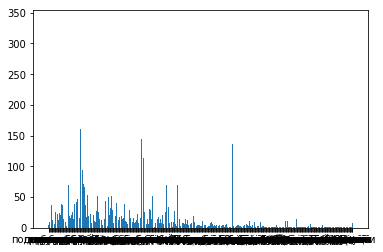

In [8]:
plt.bar(metrics_all.keys(), metrics_all.values())
plt.show()

### Гистограмма при расчете расстояния Пирсона

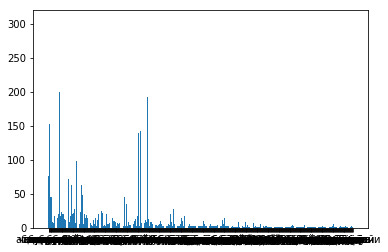
при тех же параметрах имеет более выраженные максимальные выбросы, поэтому лучше использовать косинусное сравнение

In [9]:
df_words = pd.DataFrame.from_dict(metrics_all, orient='index',columns=['Частота'])

In [10]:
df_words.head()

,Частота
деревне,4
подпрыгивает,10
что,77
татар,44
куклу,37


In [11]:
ser_count_word_sent = pd.Series(words_in_sent_count)

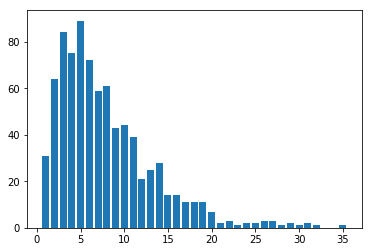

In [12]:
plt.bar(ser_count_word_sent.keys(), ser_count_word_sent.values)
plt.show()

In [13]:
ser_count_sign_sent = pd.Series(sentences_count_sign)


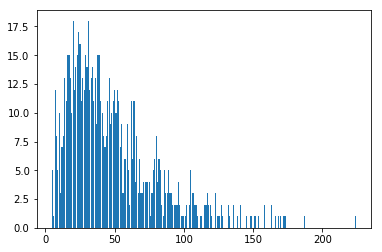

In [14]:
plt.bar(ser_count_sign_sent.keys(), ser_count_sign_sent.values)
plt.show()